In [1]:
#Pytorch NN model derived from Esben Jannik Bjerrum and Cheminformania/Wildcardconsulting.dk 


#!conda install -c anaconda scikit-learn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
#usising active compound for HTR6 gene from  ExCAPE chemogenomics database

file = '5HT6.csv'
data = pd.read_csv(file)
data.head()

,Ambit_InchiKey,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,SMILES
0,CZAIAVKCVKTXDB-PKRZOPRNNA-N,CHEMBL497963,3362,A,5.0000,chembl20,556323,9606,HTR6,2105,N=1C=2C=CC=C(OCCN3CCC(CC3)CC=4C=CC=C(C4)N=S(C)...
1,CZAYHMNNMGGUNI-HEGJIAMLNA-N,CHEMBL1834346,3362,A,7.3000,chembl20,771219,9606,HTR6,2105,C(C1(C=NN(C1)/C(=N/S(=O)(C=2C=C(C=CC2)Cl)=O)/N...
2,CZAYHMNNMGGUNI-YWFSPISDNA-N,56593803,3362,A,7.3019,pubchem,621208,9606,HTR6,2105,ClC=1C=C(S(=O)(=O)N/C(/N2N=CC(C2)(CC)CC)=N/CC)...
3,CZBRRHLYIHWSOA-UHFFFAOYNA-N,CHEMBL517503,3362,A,8.1000,chembl20,535877,9606,HTR6,2105,C=1C=2N(C=CC2C=C3C1CCNCC3)S(C=4C=CSC4)(=O)=O
4,CZEUYEVFOZRSCP-CQSZACIVNA-N,CHEMBL609742,3362,A,8.8900,chembl20,310551,9606,HTR6,2105,C=1C=CC(=C(C1)S(NC=2C=CC=3NC=C(C3C2)C[C@@H]4NC...


,SMILES,Molecule
0,N=1C=2C=CC=C(OCCN3CCC(CC3)CC=4C=CC=C(C4)N=S(C)...,

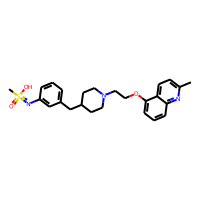

In [3]:
from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools, AllChem

# addition of RDkit molecule to pandas dataframe (which is already parsed as picture in IPythhon)
PandasTools.AddMoleculeColumnToFrame(data,'SMILES','Molecule')
data[["SMILES","Molecule"]].head(1)

In [4]:
# check if any problematic smiles was generated

data.Molecule.isna().sum()

0

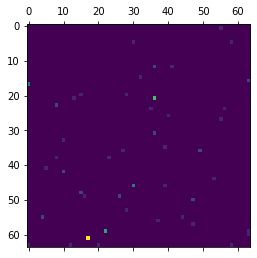

In [5]:
def mol2fp(mol):
    '''
    Generator of Morgans fingerprint from RDkit object
    '''
    
    fp = AllChem.GetHashedMorganFingerprint(mol, 2, nBits=4096)
    ar = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, ar)
    return ar
     
fp = mol2fp(Chem.MolFromSmiles(data.loc[5,"SMILES"]))
_ = plt.matshow(fp.reshape((64,-1)))

In [6]:
data["FPs"] = data.Molecule.apply(mol2fp)

In [7]:
'''PyTorch need to train on pytorch tensors,
which are similar to Numpy arrays, 
but with some extra features such a the ability
to be transferred to the GPU memory. 
But first we’ll devide the dataset into train,
validation and test using scikit learn.'''

# ????
X = np.stack(data.FPs.values)
print(X.shape)

(2391, 4096)


In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [9]:
y = data.pXC50.values.reshape((-1,1))
X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.10, random_state=42)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train,  test_size=0.05, random_state=42)
#Normalizing output using standard scaling
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)
y_validation = scaler.transform(y_validation)

In [10]:
# We'll remove low variance features
from sklearn.feature_selection import VarianceThreshold
feature_select = VarianceThreshold(threshold=0.05)
X_train = feature_select.fit_transform(X_train)
X_validation = feature_select.transform(X_validation)
X_test = feature_select.transform(X_test)
X_train.shape

(2043, 213)

In [11]:
# Let's get those arrays transfered to the GPU memory as tensors
cuda = '"cuda:0" if torch.cuda.is_available() else'
device = torch.device("cpu")
print(device)

X_train = torch.tensor(X_train, device=device).float()
X_test = torch.tensor(X_test, device=device).float()
X_validation = torch.tensor(X_validation, device=device).float()
y_train = torch.tensor(y_train, device=device).float()
y_test = torch.tensor(y_test, device=device).float()
y_validation = torch.tensor(y_validation, device=device).float()
X_train

cpu


tensor([[0., 0., 1.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 1., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]])

In [12]:
X_train.shape

torch.Size([2043, 213])

In [13]:
from torch.utils.data import TensorDataset
train_dataset = TensorDataset(X_train, y_train)
validation_dataset = TensorDataset(X_validation, y_validation)

In [14]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=256,
                                          shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset,
                                          batch_size=256,
                                          shuffle=False)

In [15]:
# NN model, really have no idea how it works

class Net(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate, out_size):
        super(Net, self).__init__()
        # Three layers and a output layer
        self.fc1 = nn.Linear(input_size, hidden_size)  # 1st Full-Connected Layer
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc_out = nn.Linear(hidden_size, out_size) # Output layer
        #Layer normalization for faster training
        self.ln1 = nn.LayerNorm(hidden_size)
        self.ln2 = nn.LayerNorm(hidden_size)
        self.ln3 = nn.LayerNorm(hidden_size)        
        #LeakyReLU will be used as the activation function
        self.activation = nn.LeakyReLU()
        #Dropout for regularization
        self.dropout = nn.Dropout(dropout_rate)
     
    def forward(self, x):# Forward pass: stacking each layer together
        # Fully connected =&amp;gt; Layer Norm =&amp;gt; LeakyReLU =&amp;gt; Dropout times 3
        out = self.fc1(x)
        out = self.ln1(out)
        out = self.activation(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.ln2(out)
        out = self.activation(out)
        out = self.dropout(out)
        out = self.fc3(out)
        out = self.ln3(out)
        out = self.activation(out)
        out = self.dropout(out)
        #Final output layer
        out = self.fc_out(out)
        return out

In [16]:
#Defining the hyperparameters
input_size = X_train.size()[-1]     # The input size should fit our fingerprint size
hidden_size = 1024   # The size of the hidden layer
dropout_rate = 0.80    # The dropout rate
output_size = 1        # This is just a single task, so this will be one
learning_rate = 0.001  # The learning rate for the optimizer
model = Net(input_size, hidden_size, dropout_rate, output_size)

In [17]:
#model.cuda()

In [18]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [19]:
model.train() #Ensure the network is in "train" mode with dropouts active
epochs = 200
for e in range(epochs):
    running_loss = 0
    for fps, labels in train_loader:
        # Training pass
        optimizer.zero_grad() # Initialize the gradients, which will be recorded during the forward pa
         
        output = model(fps) #Forward pass of the mini-batch
        loss = criterion(output, labels) #Computing the loss
        loss.backward() # calculate the backward pass
        optimizer.step() # Optimize the weights
         
        running_loss += loss.item()
    else:
        if e%10 == 0:
            validation_loss = torch.mean(( y_validation - model(X_validation) )**2).item()
            print("Epoch: %3i Training loss: %0.2F Validation loss: %0.2F"%(e,(running_loss/len(train_loader)), validation_loss))


/home/anton/anaconda3/envs/my-rdkit-env/lib/python3.9/site-packages/torch/autograd/__init__.py:173: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755849709/work/c10/cuda/CUDAFunctions.cpp:112.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch:   0 Training loss: 1.65 Validation loss: 1.61
Epoch:  10 Training loss: 0.61 Validation loss: 0.72
Epoch:  20 Training loss: 0.48 Validation loss: 0.63
Epoch:  30 Training loss: 0.41 Validation loss: 0.65
Epoch:  40 Training loss: 0.35 Validation loss: 0.49
Epoch:  50 Training loss: 0.33 Validation loss: 0.48
Epoch:  60 Training loss: 0.30 Validation loss: 0.54
Epoch:  70 Training loss: 0.29 Validation loss: 0.52
Epoch:  80 Training loss: 0.26 Validation loss: 0.51
Epoch:  90 Training loss: 0.25 Validation loss: 0.49
Epoch: 100 Training loss: 0.24 Validation loss: 0.52
Epoch: 110 Training loss: 0.24 Validation loss: 0.51
Epoch: 120 Training loss: 0.22 Validation loss: 0.51
Epoch: 130 Training loss: 0.20 Validation loss: 0.45
Epoch: 140 Training loss: 0.19 Validation loss: 0.47
Epoch: 150 Training loss: 0.20 Validation loss: 0.54
Epoch: 160 Training loss: 0.19 Validation loss: 0.57
Epoch: 170 Training loss: 0.18 Validation loss: 0.53
Epoch: 180 Training loss: 0.17 Validation loss

In [20]:
model.eval() #Swith to evaluation mode, where dropout is switched off
y_pred_train = model(X_train)
y_pred_validation = model(X_validation)
y_pred_test = model(X_test)

In [21]:
torch.mean(( y_train - y_pred_train )**2).item()

0.08350811898708344

In [22]:

torch.mean(( y_validation - y_pred_validation )**2).item()


0.39650586247444153

In [23]:
torch.mean(( y_test - y_pred_test )**2).item()

0.2778458893299103

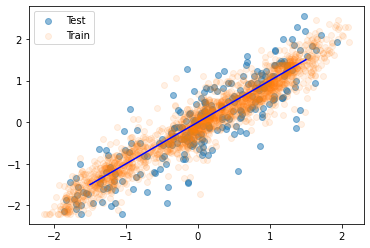

In [24]:
def flatten(tensor):
    return tensor.cpu().detach().numpy().flatten()

_ = plt.scatter(flatten(y_pred_test), flatten(y_test), alpha=0.5, label="Test")
_ = plt.scatter(flatten(y_pred_train), flatten(y_train), alpha=0.1, label="Train")
_ = plt.legend()
_ = plt.plot([-1.5, 1.5], [-1.5,1.5], c="b")

In [25]:
def predict_smiles(smiles):
    fp =mol2fp(Chem.MolFromSmiles(smiles)).reshape(1,-1)
    fp_filtered = feature_select.transform(fp)
    fp_tensor = torch.tensor(fp_filtered, device=device).float()
    prediction = model(fp_tensor)
    #return prediction.cpu().detach().numpy()
    pXC50 = scaler.inverse_transform(prediction.cpu().detach().numpy())
    return pXC50[0][0]
predict_smiles('CN1CC2c3ccccc3Oc3ccc(Cl)cc3C2C1')

6.1375313

In [27]:
base = 'pubchem.chembl.dataset4publication_inchi_smiles_v2.tsv'
output = {'smiles': [],
          'pXC50': [],
          'ID': []
         }

In [28]:
base_tsv = pd.read_csv(base, sep='\t', usecols=['DB', 'Original_Entry_ID', 'SMILES'])

In [29]:
len(base_tsv.SMILES.values)

56853341

In [30]:
len(set(base_tsv.SMILES.values))

1062737

In [31]:
from IPython.display import clear_output

activity = []
i = 0
for smiles in set(base_tsv.SMILES.values):
    i+= 1
    if i % 1000 == 0:
        clear_output(wait=True)
        print(f"Compound numer {i}")
    try:
        activity.append(predict_smiles(smiles))
    except:
        activity.append(np.nan)

Compound numer 1062000


In [32]:
out = {'smiles': list(set(base_tsv.SMILES.values)),
          'pXC50': activity
         }
df = pd.DataFrame(out)
df = df.sort_values('pXC50', ascending=True)

In [33]:
#df.to_csv('first_nn_htr6.csv')

In [34]:
df.smiles[884107]

'S(CC(=O)N(C(C(=O)NC(C)(C)C)C1=CC=C(OC)C=C1)C2=CC=CC=C2)C=3N(C(=NN3)C=4C=CC=CC4)C'

In [35]:
#save part to swissADME analysis
swissADME = df.head(1000)

In [36]:
#merge with original table
swissADME = pd.merge(swissADME,base_tsv,how='left',left_on='smiles',right_on='SMILES')


In [37]:
#swissADME.drop('smiles', axis='columns', inplace=True)
swissADME.drop_duplicates(inplace=True)
swissADME

,smiles,pXC50,Original_Entry_ID,DB,SMILES
0,OC=1N(CN2C(CCC2)CC)C=NC=3C1N=C4C3C=CC=C4,4.941354,3238198,pubchem_screening,OC=1N(CN2C(CCC2)CC)C=NC=3C1N=C4C3C=CC=C4
3,OC=1N(CN2C(CCC2)CC)C=NC=3C1N=C4C3C=CC=C4,4.941354,3238198,pubchem,OC=1N(CN2C(CCC2)CC)C=NC=3C1N=C4C3C=CC=C4
241,OC=1N(C=NC=2C1N=C3C2C=CC=C3)CN4C(CCC4)CC,4.941354,CHEMBL1392212,chembl20,OC=1N(C=NC=2C1N=C3C2C=CC=C3)CN4C(CCC4)CC
248,S=1(O)(O)=CC2N(/C(/SC2C1)=N/C(=O)C3CCCCC3)C4=C...,4.999475,4908209,pubchem_screening,S=1(O)(O)=CC2N(/C(/SC2C1)=N/C(=O)C3CCCCC3)C4=C...
251,S=1(O)(O)=CC2N(/C(/SC2C1)=N/C(=O)C3CCCCC3)C4=C...,4.999475,4908209,pubchem,S=1(O)(O)=CC2N(/C(/SC2C1)=N/C(=O)C3CCCCC3)C4=C...
...,...,...,...,...,...
65263,C=1C(=NC(=C(C1)O)/C=N/O)CCCN2C(C3=CC(=C(C=C3CC...,5.164073,CHEMBL2181430,chembl20,C=1C(=NC(=C(C1)O)/C=N/O)CCCN2C(C3=CC(=C(C=C3CC...
65264,O(C=1C=C2C(N(CCC2=CC1OC)CCCC3=NC(=C(O)C=C3)C=N...,5.164073,71453921,pubchem,O(C=1C=C2C(N(CCC2=CC1OC)CCCC3=NC(=C(O)C=C3)C=N...
65265,O1C(NC2CCN(CC2)CC3=CC(OCC)=C(OC)C=C3)=NC=4C1=C...,5.164099,46882666,pubchem,O1C(NC2CCN(CC2)CC3=CC(OCC)=C(OC)C=C3)=NC=4C1=C...
65266,O=C(N=C(N)N)CC=1C=CC(NC=2N=C(N=C3N(CC)C=NC32)C...,5.164137,44460095,pubchem_screening,O=C(N=C(N)N)CC=1C=CC(NC=2N=C(N=C3N(CC)C=NC32)C...


In [38]:
#swissADME.to_csv('swissADME.csv')

In [39]:
from rdkit import Chem
from rdkit.Chem import Descriptors

PandasTools.AddMoleculeColumnToFrame(swissADME,'SMILES','Molecule')
swissADME['MW'] = swissADME.Molecule.apply(Chem.Descriptors.MolWt)

,smiles,pXC50,Original_Entry_ID,DB,SMILES,Molecule,MW
0,OC=1N(CN2C(CCC2)CC)C=NC=3C1N=C4C3C=CC=C4,4.941354,3238198,pubchem_screening,OC=1N(CN2C(CCC2)CC)C=NC=3C1N=C4C3C=CC=C4,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",296.374
3,OC=1N(CN2C(CCC2)CC)C=NC=3C1N=C4C3C=CC=C4,4.941354,3238198,pubchem,OC=1N(CN2C(CCC2)CC)C=NC=3C1N=C4C3C=CC=C4,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",296.374
241,OC=1N(C=NC=2C1N=C3C2C=CC=C3)CN4C(CCC4)CC,4.941354,CHEMBL1392212,chembl20,OC=1N(C=NC=2C1N=C3C2C=CC=C3)CN4C(CCC4)CC,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",296.374
248,S=1(O)(O)=CC2N(/C(/SC2C1)=N/C(=O)C3CCCCC3)C4=C...,4.999475,4908209,pubchem_screening,S=1(O)(O)=CC2N(/C(/SC2C1)=N/C(=O)C3CCCCC3)C4=C...,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",378.519
251,S=1(O)(O)=CC2N(/C(/SC2C1)=N/C(=O)C3CCCCC3)C4=C...,4.999475,4908209,pubchem,S=1(O)(O)=CC2N(/C(/SC2C1)=N/C(=O)C3CCCCC3)C4=C...,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",378.519

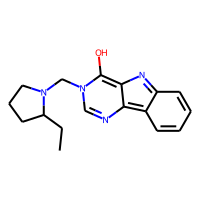
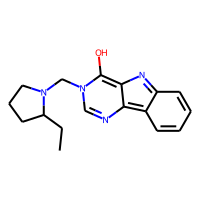
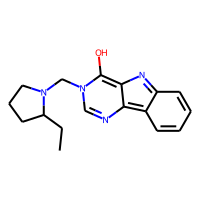
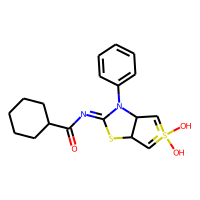
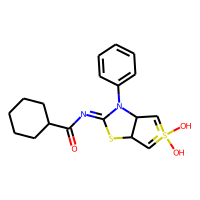

In [40]:
swissADME.head()

In [41]:
from rdkit.Chem import Lipinski

In [42]:
swissADME['HA'] = swissADME.Molecule.apply(Chem.Lipinski.NumHAcceptors)
swissADME['HD'] = swissADME.Molecule.apply(Chem.Lipinski.NumHDonors)

,smiles,pXC50,Original_Entry_ID,DB,SMILES,Molecule,MW,HA,HD,logP
0,OC=1N(CN2C(CCC2)CC)C=NC=3C1N=C4C3C=CC=C4,4.941354,3238198,pubchem_screening,OC=1N(CN2C(CCC2)CC)C=NC=3C1N=C4C3C=CC=C4,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",296.374,5,1,3.0736
3,OC=1N(CN2C(CCC2)CC)C=NC=3C1N=C4C3C=CC=C4,4.941354,3238198,pubchem,OC=1N(CN2C(CCC2)CC)C=NC=3C1N=C4C3C=CC=C4,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",296.374,5,1,3.0736
241,OC=1N(C=NC=2C1N=C3C2C=CC=C3)CN4C(CCC4)CC,4.941354,CHEMBL1392212,chembl20,OC=1N(C=NC=2C1N=C3C2C=CC=C3)CN4C(CCC4)CC,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",296.374,5,1,3.0736
248,S=1(O)(O)=CC2N(/C(/SC2C1)=N/C(=O)C3CCCCC3)C4=C...,4.999475,4908209,pubchem_screening,S=1(O)(O)=CC2N(/C(/SC2C1)=N/C(=O)C3CCCCC3)C4=C...,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",378.519,4,2,3.8085
251,S=1(O)(O)=CC2N(/C(/SC2C1)=N/C(=O)C3CCCCC3)C4=C...,4.999475,4908209,pubchem,S=1(O)(O)=CC2N(/C(/SC2C1)=N/C(=O)C3CCCCC3)C4=C...,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",378.519,4,2,3.8085

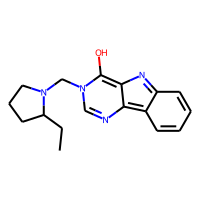
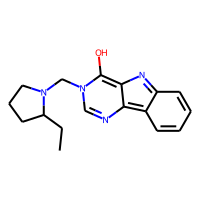
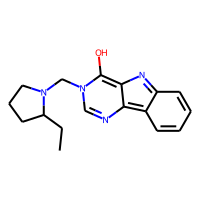
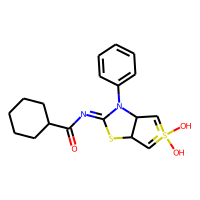
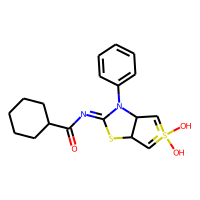

In [43]:
from rdkit.Chem import Crippen
swissADME['logP'] = swissADME.Molecule.apply(Chem.Crippen.MolLogP)
swissADME.head()

In [44]:
# implementation of Lipinski rule of five
def rule_of_five(df):
    f = (df.MW < 500) & (df.logP < 5) & (df.HA < 10) & (df.HD < 5)
    df['Lipinski rule'] = f
    return df

,smiles,pXC50,Original_Entry_ID,DB,SMILES,Molecule,MW,HA,HD,logP,Lipinski rule
0,OC=1N(CN2C(CCC2)CC)C=NC=3C1N=C4C3C=CC=C4,4.941354,3238198,pubchem_screening,OC=1N(CN2C(CCC2)CC)C=NC=3C1N=C4C3C=CC=C4,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",296.374,5,1,3.07360,True
3,OC=1N(CN2C(CCC2)CC)C=NC=3C1N=C4C3C=CC=C4,4.941354,3238198,pubchem,OC=1N(CN2C(CCC2)CC)C=NC=3C1N=C4C3C=CC=C4,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",296.374,5,1,3.07360,True
241,OC=1N(C=NC=2C1N=C3C2C=CC=C3)CN4C(CCC4)CC,4.941354,CHEMBL1392212,chembl20,OC=1N(C=NC=2C1N=C3C2C=CC=C3)CN4C(CCC4)CC,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",296.374,5,1,3.07360,True
248,S=1(O)(O)=CC2N(/C(/SC2C1)=N/C(=O)C3CCCCC3)C4=C...,4.999475,4908209,pubchem_screening,S=1(O)(O)=CC2N(/C(/SC2C1)=N/C(=O)C3CCCCC3)C4=C...,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",378.519,4,2,3.80850,True
251,S=1(O)(O)=CC2N(/C(/SC2C1)=N/C(=O)C3CCCCC3)C4=C...,4.999475,4908209,pubchem,S=1(O)(O)=CC2N(/C(/SC2C1)=N/C(=O)C3CCCCC3)C4=C...,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",378.519,4,2,3.80850,True
...,...,...,...,...,...,...,...,...,...,...,...
65263,C=1C(=NC(=C(C1)O)/C=N/O)CCCN2C(C3=CC(=C(C=C3CC...,5.164073,CHEMBL2181430,chembl20,C=1C(=NC(=C(C1)O)/C=N/O)CCCN2C(C3=CC(=C(C=C3CC...,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",447.535,7,2,4.19280,True
65264,O(C=1C=C2C(N(CCC2=CC1OC)CCCC3=NC(=C(O)C=C3)C=N...,5.164073,71453921,pubchem,O(C=1C=C2C(N(CCC2=CC1OC)CCCC3=NC(=C(O)C=C3)C=N...,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",447.535,7,2,4.19280,True
65265,O1C(NC2CCN(CC2)CC3=CC(OCC)=C(OC)C=C3)=NC=4C1=C...,5.164099,46882666,pubchem,O1C(NC2CCN(CC2)CC3=CC(OCC)=C(OC)C=C3)=NC=4C1=C...,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",382.464,7,1,3.70660,True
65266,O=C(N=C(N)N)CC=1C=CC(NC=2N=C(N=C3N(CC)C=NC32)C...,5.164137,44460095,pubchem_screening,O=C(N=C(N)N)CC=1C=CC(NC=2N=C(N=C3N(CC)C=NC32)C...,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",363.385,7,3,0.80398,True

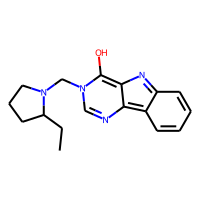
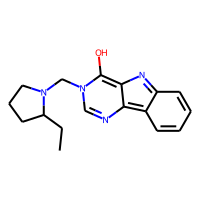
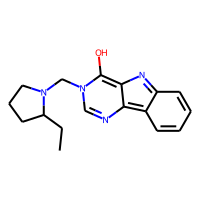
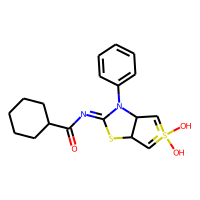
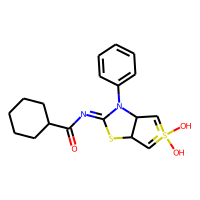
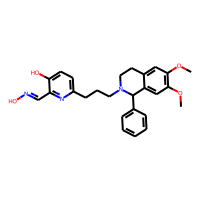
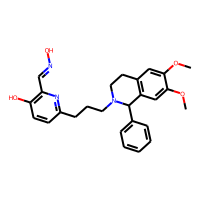
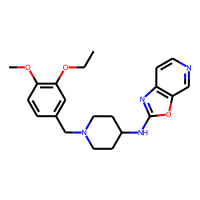
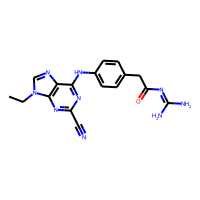
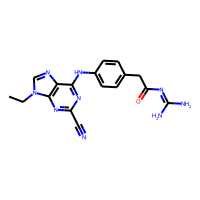

In [45]:
swissADME = rule_of_five(swissADME)
swissADME

In [46]:
swissADME.drop('Molecule', axis='columns', inplace=True)


In [1]:
cleaned = swissADME.drop_duplicates()
cleaned.to_csv('swissADME_big_1.csv')

NameError: name 'swissADME' is not defined